In [ ]:
from data_loader import load_datasets
from models.hf_model import HuggingFaceModel
from models.llm_llamaapi_model import LLMModelLLAMA
from models.llm_openai_model import LLMModelOpenAI
from models.baseline_model import BaselineModel
from evaluator import evaluate_model
import config

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


AVAILABLE_MODELS = {
    "xlmr_classifier": (HuggingFaceModel, "s-nlp/xlmr_formality_classifier"),
    "deberta_large_ranker": (HuggingFaceModel, "s-nlp/deberta-large-formality-ranker"),
    "mdistilbert_ranker": (HuggingFaceModel, "s-nlp/mdistilbert-base-formality-ranker"),
    "gpt4o-mini": (LLMModelOpenAI, "4o-mini"),
    "gpt4o": (LLMModelOpenAI, "gpt-4o"),
    "llama11b": (LLMModelLLAMA, "llama3.2-11b-vision"),
    "llama70b": (LLMModelLLAMA, "llama3.3-70b"),
    "deepseek-v3": (LLMModelLLAMA, "deepseek-v3"),
    "baseline": (BaselineModel, "baseline_model")
}



dataset_subset = "education"  # None to select all datasets, can be set to specific subset like "education"
dataset_length = None  # None to all lenghts of sentences, can be set to specific lenghts like "long"

In [4]:

sentences, true_labels, sentence_types, sentence_lengths = load_datasets(config.DATASET_DIR, subset_prefix=dataset_subset, subset_length=dataset_length)

Filtering datasets for subset prefix: 'education'
Total sentences loaded for subset 'education': 300


In [ ]:
# --- 2. Initialize Model ---
model_name = "baseline" 
if model_name not in AVAILABLE_MODELS:
    print(f"Error: Model '{model_name}' not recognized. Available: {list(AVAILABLE_MODELS.keys())}")

model_class, model_identifier = AVAILABLE_MODELS[model_name]
print(f"\nInitializing model: {model_class.__name__} ({model_identifier})...")

model = model_class(model_identifier)
print(f"Model '{model_name}' initialized.")


scores = model.predict(sentences)

evaluation_results = evaluate_model(scores, true_labels)

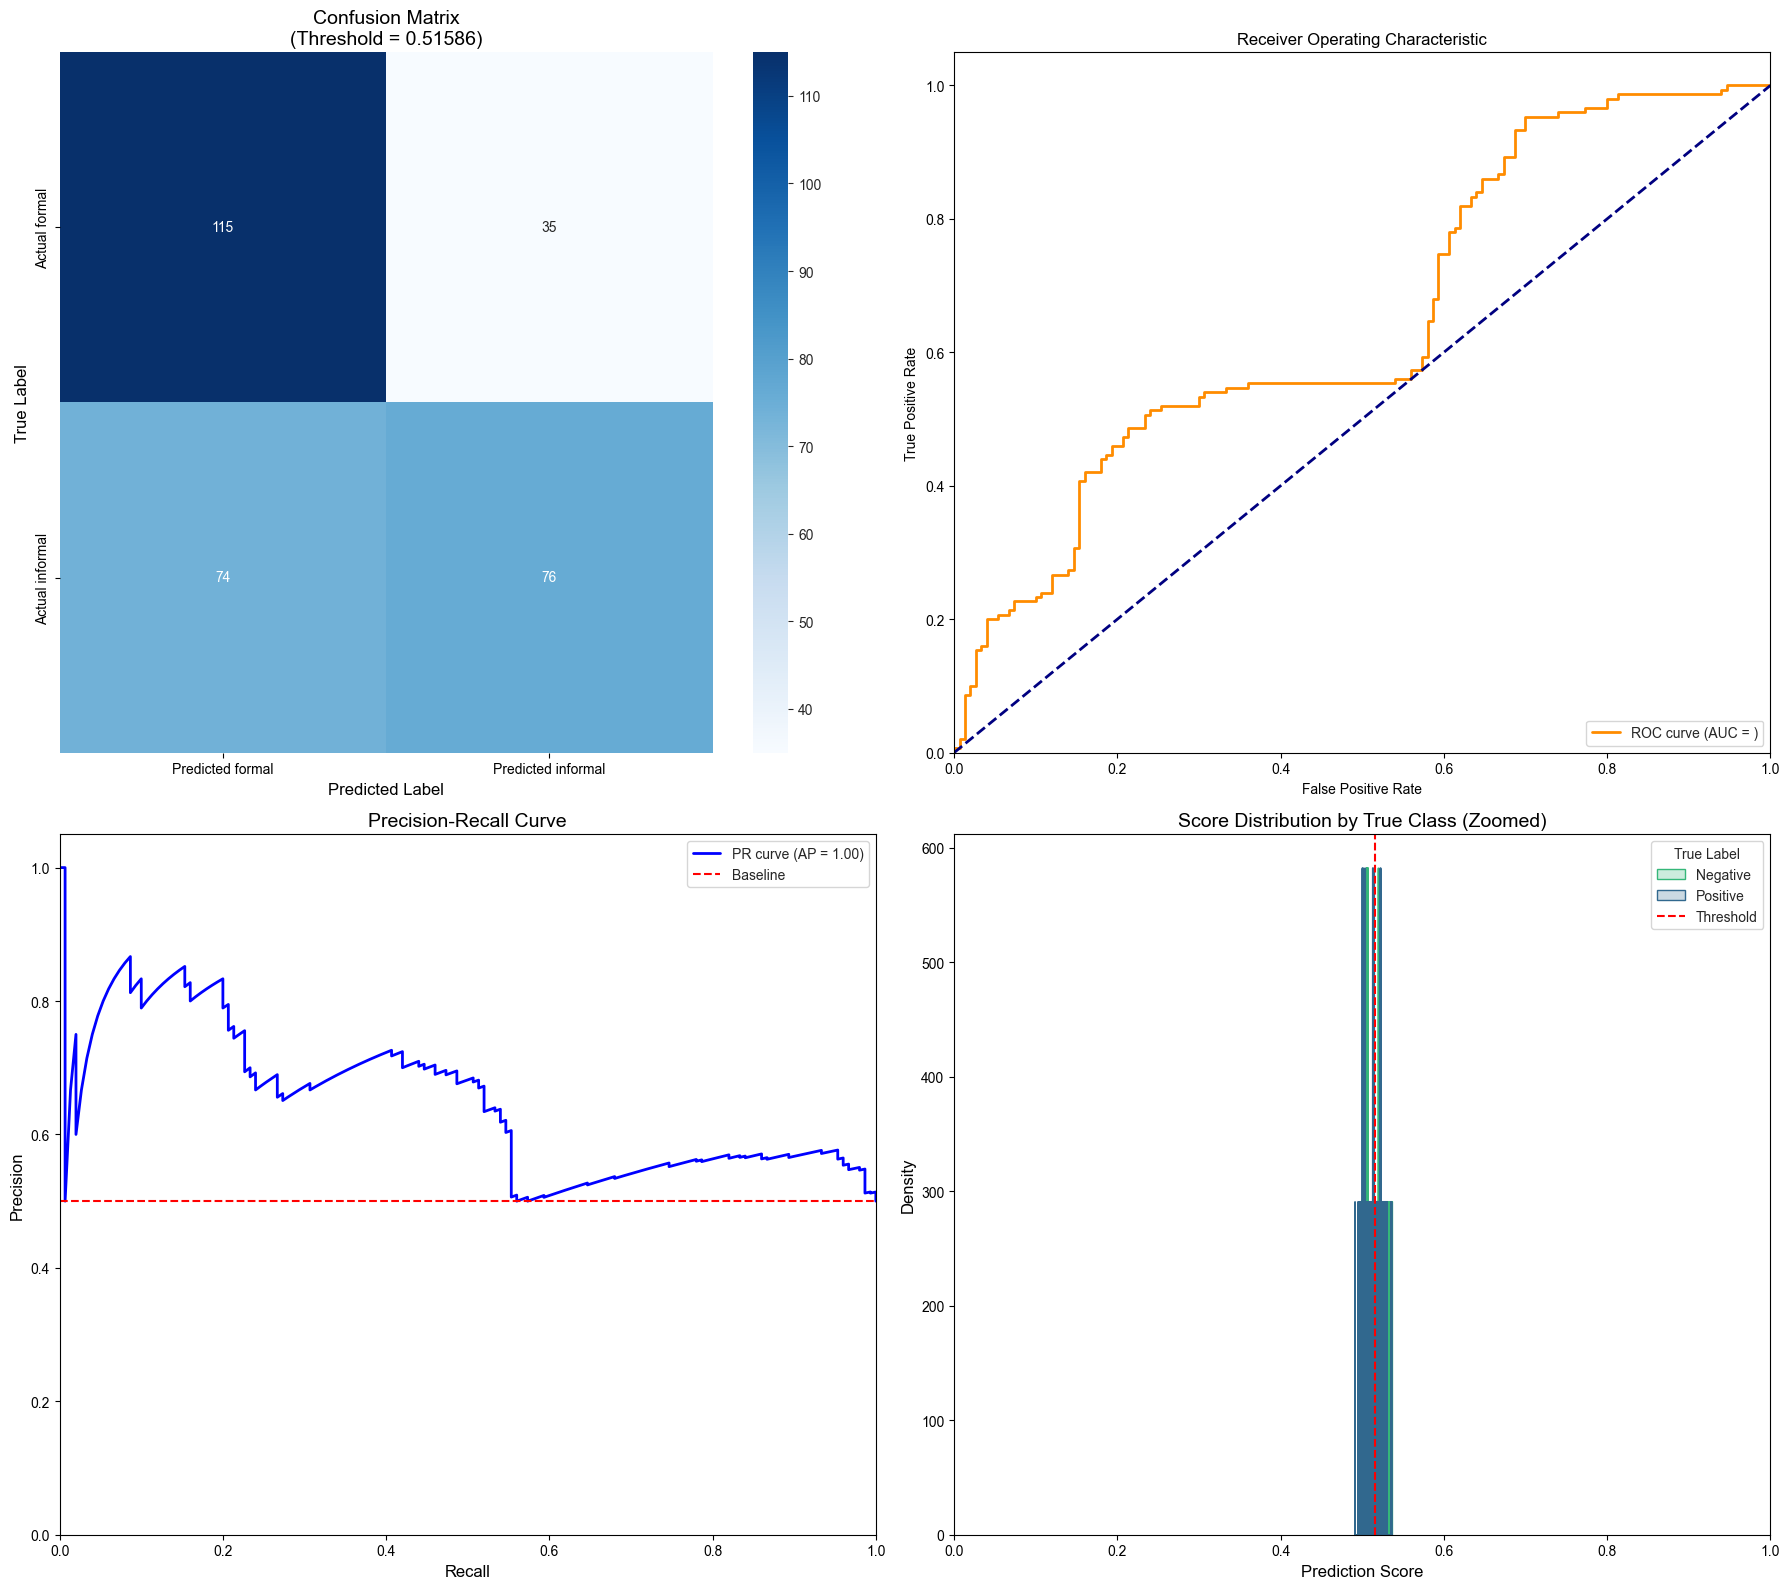

In [ ]:



threshold = evaluation_results['threshold_applied']
fig, axs = plt.subplots(2, 2, figsize=(18, 16))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.set_style("whitegrid")

# 1. Confusion Matrix Heatmap
cm = evaluation_results['confusion_matrix']
ax = axs[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
           xticklabels=['Predicted formal', 'Predicted informal'],
           yticklabels=['Actual formal', 'Actual informal'])
ax.set_title(f'Confusion Matrix\n(Threshold = {threshold:.5f})', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

# 2. ROC Curve
roc_data = evaluation_results['roc_curve']
fpr = roc_data['fpr']
tpr = roc_data['tpr']
thresholds = roc_data['thresholds']

# Plotting the ROC Curve
ax = axs[0, 1]
ax.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = )')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

# 3. Precision-Recall Curve
precision = evaluation_results['pr_curve']['precision']
recall = evaluation_results['pr_curve']['recall']

ax = axs[1, 0]
ax.plot(recall, precision, color='blue', lw=2,
        label=f'PR curve (AP = {1:.2f})')
baseline = np.mean(evaluation_results['true_labels'])
ax.plot([0, 1], [baseline, baseline], color='red', linestyle='--',
        label='Baseline')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=14)
ax.legend(loc="upper right")

# 4. Score Distribution with True Labels
ax = axs[1, 1]
scores = evaluation_results['scores']
true_labels = evaluation_results['true_labels']

# Create the histogram plot
sns.histplot(
    x=scores, hue=true_labels, element='step',
    stat='density', common_norm=False, palette='viridis', ax=ax,
    bins=2000  # Increase number of bins for better resolution
)

# Set axis limits to focus on the dense region (adjust these values accordingly)
zoom_left = 0  # Example left boundary - replace with your value
zoom_right = 1  # Example right boundary - replace with your value
ax.set_xlim(zoom_left, zoom_right)

# Add threshold line and labels
ax.axvline(threshold, color='red', linestyle='--', label='Threshold')
ax.set_title('Score Distribution by True Class (Zoomed)', fontsize=14)
ax.set_xlabel('Prediction Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(title='True Label', labels=['Negative', 'Positive', 'Threshold'])

plt.tight_layout()
plt.show()
